# Prediction of missing Tully-Fisher distance errors in NED-D

Companion notebook for the "Predicting extragalactic distance errors using bayesian inference in multi measurement catalogues" paper, Monthly Notices of the Royal Astronomical Society, Volume 485, Issue 3, May 2019, Pages 4343–4358, https://doi.org/10.1093/mnras/stz615

This notebook shows:

- An analysis of galaxies in NED-D which do not report a distance error for a TFR measurement and do not have additional TFR measurements with a reported error. We call these, "no-error" galaxies.
- A prediction of H and M errors for no-error galaxies based on the Bayesian regression models (linear and quadratic) in the [previous notebook](bayesian_models.ipynb)

In [ ]:
%%bash
# Here we download the pre-computed TFR posterior samples required to predict missing errors
# and the database of unreported TFR errors in NED-D
wget https://github.com/saint-germain/anisotropias/raw/master/posterior_lm.txt
wget https://github.com/saint-germain/anisotropias/raw/master/posterior_lh.txt
wget https://github.com/saint-germain/anisotropias/raw/master/unreportedTF.csv
wget https://github.com/saint-germain/anisotropias/raw/master/bootstrap_results_2018.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
current_palette = sns.color_palette()

In [2]:
# Load the information
samples1=np.loadtxt('posterior_lh.txt') # posterior samples for H model
samples2=np.loadtxt('posterior_lm.txt') # posterior samples for M model
odf=pd.read_csv('unreportedTF.csv') # database of no-error galaxies

TFR distance measurements without reported errors is: 1949
Number of galaxies without reported TF errors: 884
Fraction of galaxies with 1 no-error measurement:  56
95% of galaxies have less than  4.0  no-error measurements
Max. number of no-error measurements: 6


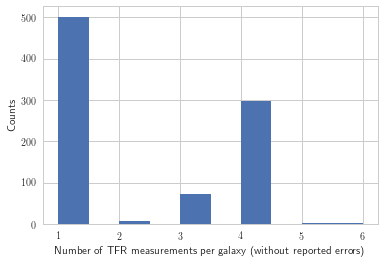

In [3]:
# Here we plot a histogram that shows that many galaxies have repeated distance measurements without reported errors
counter=collections.Counter(odf['Galaxy ID'])
norep=np.array(list(counter.values()))
plt.hist(norep)
plt.xlabel("Number of TFR measurements per galaxy (without reported errors)")
plt.ylabel('Counts')
print('TFR distance measurements without reported errors is:',str(len(odf)))
print('Number of galaxies without reported TF errors:',len(norep))
print('Fraction of galaxies with 1 no-error measurement: ',100*(norep==1).sum()//len(norep))
print('95% of galaxies have less than ',np.percentile(norep,95),' no-error measurements')
print('Max. number of no-error measurements:',norep.max())

Text(0,0.5,'Counts')

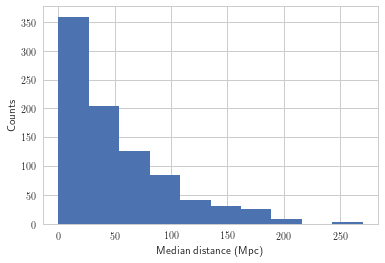

In [4]:
# Calculation and histogram of median distance of no-error galaxies
meddist=[]
for i in counter.keys():
    dummy=odf[odf['Galaxy ID']==i]
    meddist+=[np.median(dummy['D (Mpc)'])]
meddist=np.array(meddist)
plt.hist(meddist)
plt.xlabel('Median distance (Mpc)')
plt.ylabel('Counts')

In [5]:
#Here we read the results from the pre-computed distance and distance errors
ndf=pd.read_csv("bootstrap_results_2018.csv")

em=ndf.meas # number of measurements

# Bootstrap (bootstrap-sampled distance posterior distribution) quantities:
dboot=ndf.dboot # bootstrap median distance (Mpc)
bootp50=ndf.bootp50 # H error (half of bootstrap 84th-16th distance percentile) (Mpc)
bootmad=ndf.bootmad # M error (Median Absolute Deviation of bootstrap) (Mpc)

In [6]:
# we recover the data used in the succesful bayesian linear model for H/M errors
# we filter using the lowest limiting number of measurements per galaxy for which the model is validated
# nhmax is 15 and  nmmax is 13 (from the bayesian_model notebook)
# this yields a filter for the minimum and maximum working range for each model
nhmax=15
filt=np.array(em)>nhmax
x1=np.array(dboot)[filt]
y1=np.array(bootp50)[filt]
filt1=(meddist<x1.max())&(meddist>x1.min())
print('Galaxies in range for H model: ',(filt1).sum()) 
nmmax=13
filt=np.array(em)>nmmax
x2=np.array(dboot)[filt]
y2=np.array(bootmad)[filt]
filt2=(meddist<x2.max())&(meddist>x2.min())
print('Galaxies in range for H model: ',(filt2).sum()) 

Galaxies in range for H model:  814
Galaxies in range for H model:  815


In [7]:
# We include the original pre-computed H errors for N>5 for plotting a comparison
filt=np.array(em)>5
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
z=np.array(bootmad)[filt]

In [8]:
# There are the expected values for the parameters in the linear model for plotting a comparison
sth1=np.median(samples1,axis=0)
sth2=np.median(samples2,axis=0)

Text(0,0.5,'$\\sigma_D$ (Mpc)')

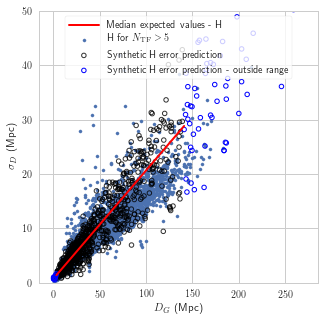

In [9]:
# This plot compares:
# original pre-computed H errors for N>5
# projection of expected values from the linear model for H errors
# predicted H errors from the linear model for no-error galaxies
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,y,s=10,label='H for $N_\mathrm{TF}>5$')
# Here we generate the synthetic H errors for no-error galaxies
xp=np.linspace(x1.min(),x1.max(),2)
modpar=samples1[np.random.randint(len(samples1))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
mark='.'
plt.scatter(meddist[filt1],ysim[filt1],linewidth=1, facecolors='none', edgecolors='k',s=80,marker=mark,label='Synthetic H error prediction',alpha=0.8)
plt.scatter(meddist[~filt1],ysim[~filt1], linewidth=1, facecolors='none', edgecolors='b',s=80,marker=mark,label='Synthetic H error prediction - outside range')
plt.plot(xp,xp*sth1[0]+sth1[1],c='r',linewidth=2,label='Median expected values - H')
plt.ylim(0,50)
plt.legend(frameon=True,loc='upper center')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')

Text(0,0.5,'$\\sigma_D$ (Mpc)')

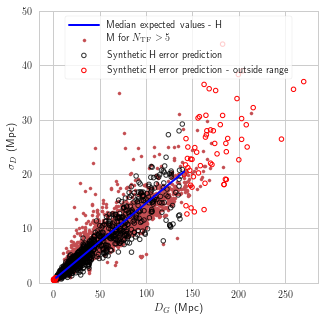

In [10]:
# This plot compares:
# original pre-computed M errors for N>5
# projection of expected values from the linear model for M errors
# predicted M errors from the linear model for no-error galaxies
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,z,c=current_palette[2],s=10,label='M for $N_\mathrm{TF}>5$')
# Here we generate the synthetic H errors for no-error galaxies
xp=np.linspace(x2.min(),x2.max(),2)
modpar=samples2[np.random.randint(len(samples2))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
mark='.'
plt.scatter(meddist[filt2],ysim[filt2],linewidth=1, facecolors='none', edgecolors='k',s=80,marker=mark,label='Synthetic H error prediction',alpha=0.8)
plt.scatter(meddist[~filt2],ysim[~filt2], linewidth=1, facecolors='none', edgecolors='r',s=80,marker=mark,label='Synthetic H error prediction - outside range')
plt.plot(xp,xp*sth2[0]+sth2[1],c='b',linewidth=2,label='Median expected values - H')
plt.ylim(0,50)
plt.legend(frameon=True,loc='upper center')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')